In [10]:
# import libraries
from cil.optimisation.functions import L2NormSquared, MixedL21Norm
from cil.optimisation.operators import GradientOperator
from cil.optimisation.algorithms import PDHG
from cil.optimisation.functions import TotalVariation
from cil.utilities import dataexample
from cil.utilities import noise
from cil.utilities.display import show2D

import matplotlib.pyplot as plt
import numpy as np

from skimage.metrics import structural_similarity as ssim

In [11]:
# Select Color or Gray denoising
case = input("Select color or gray TV-denoising (Color = 1, Gray = 0)")

Select color or gray TV-denoising (Color = 1, Gray = 0) 0


In [12]:
if case=='1':
    
    # Load a color image from the CIL gallery. 
    data = dataexample.PEPPERS.get()
    data.reorder(['horizontal_y', 'horizontal_x','channel'])
    ig = data.geometry
        
    # TV regularisation parameter
    alpha = 0.3
    
elif case=='0':
    
    # Load an image from the CIL gallery. 
    data = dataexample.SHAPES.get()
    ig = data.geometry    
    
    # TV regularisation parameter
    alpha = 0.1
    
# Add gaussian noise
noisy_data = noise.gaussian(data, seed = 10, var = 0.005)

In [13]:
# Setup and run the PDHG algorithm
F = alpha * MixedL21Norm()
G = 0.5 * L2NormSquared(b=noisy_data)
K = GradientOperator(ig)

# Compute operator Norm
normK = K.norm()

# Primal & dual stepsizes
sigma = 1./normK
tau = 1./normK

pdhg = PDHG(f=F, g=G, operator=K, tau=tau, sigma=sigma,
            max_iteration = 1000, update_objective_interval = 200)
pdhg.run(verbose=2)

Initialised GradientOperator with C backend running with  20  threads
PDHG setting up
PDHG configured
     Iter   Max Iter     Time/Iter        Primal          Dual     Primal-Dual
                               [s]     Objective     Objective             Gap
        0       1000         0.000    1.03383e+04  -0.00000e+00    1.03383e+04
      200       1000         0.004    2.30411e+02   2.30072e+02    3.39206e-01
      400       1000         0.003    2.30249e+02   2.30136e+02    1.13141e-01
      600       1000         0.003    2.30210e+02   2.30148e+02    6.23703e-02
      800       1000         0.003    2.30192e+02   2.30152e+02    3.94562e-02
     1000       1000         0.003    2.30181e+02   2.30154e+02    2.68372e-02
----------------------------------------------------------------------------
     1000       1000         0.003    2.30181e+02   2.30154e+02    2.68372e-02
Stop criterion has been reached.



In [14]:
# Compute SSIM from Scikit-Image
if case=='1':
    val_ssim = ssim(data.as_array(), pdhg.solution.as_array(), data_range = 1., multichannel=True)
else:
    val_ssim = ssim(data.as_array(), pdhg.solution.as_array(), data_range = 1.)

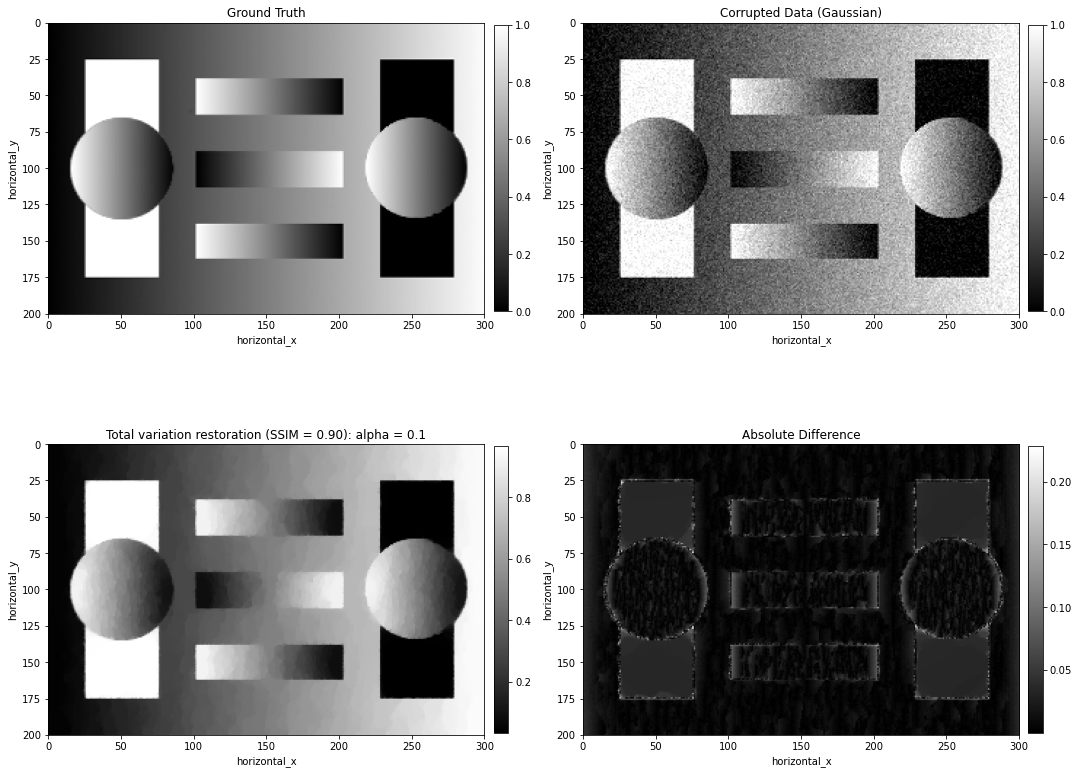

In [19]:
if case=='1':
    
    fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(10,10))
    ax[0,0].imshow(data.as_array())
    ax[0,0].set_title("Ground Truth")
    
    ax[0,1].imshow(noisy_data.as_array())
    ax[0,1].set_title("Corrupted Data (Gaussian)")
    ax[1,0].imshow(pdhg.solution.as_array())
    ax[1,0].set_title("Total variation restoration (SSIM = {:.2f}): alpha = {}".format(val_ssim, alpha))
    ax[1,1].imshow((pdhg.solution-data).abs().as_array())
    ax[1,1].set_title("Absolute Difference")
    plt.tight_layout()
    plt.show()

else:
    
    show2D([data, noisy_data, pdhg.solution, (pdhg.solution-data).abs()],
          title=["Ground Truth", 
                  "Corrupted Data (Gaussian)", 
                  "Total variation restoration (SSIM = {:.2f}): alpha = {}".format(val_ssim, alpha),
                  "Absolute Difference"],
         origin = "upper")

In [20]:
# Use Total Variation function. 
# The proximal method solves the dual of the ROF problem.
# using the Fast Gradient Projection (FGP) algoritm
fgp_tv_recon = (alpha*TotalVariation(max_iteration=500)).proximal(noisy_data, tau=1.)

Initialised GradientOperator with C backend running with  20  threads


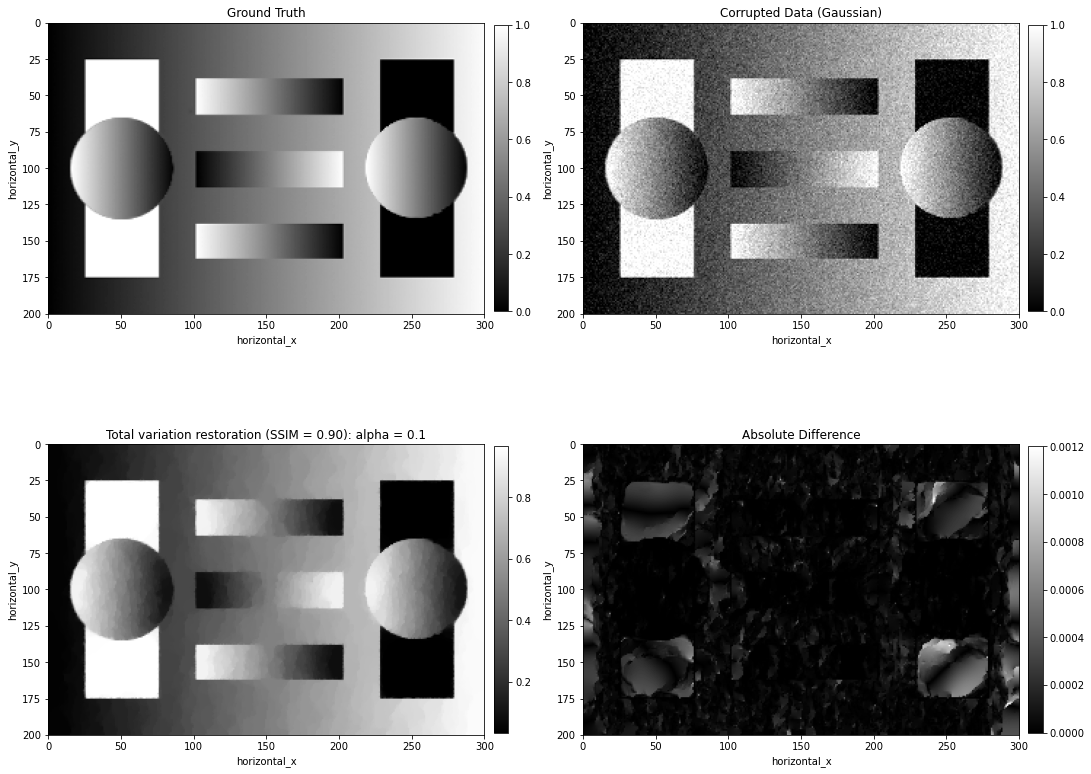

In [21]:
if case=='1':
    
    fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(10,10))
    ax[0,0].imshow(data.as_array())
    ax[0,0].set_title("Ground Truth")
    ax[0,1].imshow(noisy_data.as_array())
    ax[0,1].set_title("Corrupted Data (Gaussian)")
    ax[1,0].imshow(fgp_tv_recon.as_array())
    ax[1,0].set_title("Total variation restoration (SSIM = {:.2f}): alpha = {}".format(val_ssim, alpha))
    ax[1,1].imshow((fgp_tv_recon-data).abs().as_array())
    ax[1,1].set_title("Absolute Difference")
    plt.tight_layout()
    plt.show()

else:
    show2D([data, noisy_data, fgp_tv_recon, (fgp_tv_recon-pdhg.solution).abs()],
          title=["Ground Truth", 
                  "Corrupted Data (Gaussian)", 
                  "Total variation restoration (SSIM = {:.2f}): alpha = {}".format(val_ssim, alpha),
                  "Absolute Difference PDHG vs FGP_TV"],
         origin = "upper")